In [2]:
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import utils
from tqdm import tqdm

In [3]:
X_train, y_train = utils.load_mnist('data/numbers', kind='train')
X_test, y_test = utils.load_mnist('data/numbers', kind='t10k')

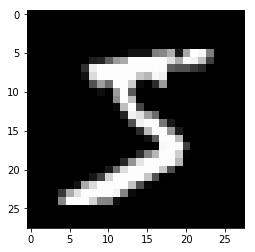

In [4]:
utils.show_image(X_train[0])

In [ ]:
class Conv:
    def __init__(self, filter_size = 3, num_filters = 8):
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, filter_size, filter_size) / 9

    def iterate_regions(self, image):
        if len(image.shape) == 3:
            h, w, _ = image.shape
        else:
            h, w = image.shape
        for i in range(h - self.filter_size + 1):
            for j in range(w - self.filter_size + 1):
                im_region = image[i:(i + self.filter_size), j:(j + self.filter_size)]
                yield np.sum(im_region, axis=2), i, j

    def forward(self, input):
        if len(input.shape) == 2:
            input = input.reshape((input.shape[0], input.shape[1], 1))
        h, w, _ = input.shape
        self.last_input = input
        output = np.zeros((h - self.filter_size + 1, w - self.filter_size + 1, self.num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))
        return output
    
    def back_prop(self, d_L_d_out, learn_rate = 0.0005):
        d_L_d_filters = np.zeros(self.filters.shape)
        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region
        
        d_loss_d_input = np.zeros(self.last_input.shape)
        for im_region, i, j in self.iterate_regions(d_L_d_out):
            d_loss_d_input[i][j] = np.sum(im_region * self.filters, axis=(0, 1, 2))
                
        self.filters -= learn_rate * d_L_d_filters
    
        return d_loss_d_input

class MaxPool:
    def __init__(self, pool_size = 2):
        self.pool_size = pool_size

    def iterate_regions(self, image):
        h, w, _ = image.shape

        for i in range(h // 2):
            for j in range(w // 2):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input
        h, w, num_filters = input.shape

        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i][j] = np.amax(im_region, axis = (0, 1))
        return output
    def back_prop(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))
            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input
    
class SoftMax:
    def __init__(self, input_len, nodes_num = 10, learn_rate = 0.0005):
        self.learn_rate = learn_rate
        self.input_len = input_len
        self.weights = np.random.randn(input_len, nodes_num) / input_len
        self.biases = np.zeros(nodes_num)
    
    def forward(self, input):
        self.last_input_shape = input.shape
        input = input.flatten()
        self.last_input = input
        input_len, nodes = self.weights.shape
        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals
        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)
    
    def back_prop(self, d_L_d_out):
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue
            t_exp = np.exp(self.last_totals)
            S = np.sum(t_exp)
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
            
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights
 
            d_L_d_t = gradient * d_out_d_t
 
            # Gradients of loss against weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t
            self.weights -= self.learn_rate * d_L_d_w
            self.biases -= self.learn_rate * d_L_d_b
            
            return d_L_d_inputs.reshape(self.last_input_shape)

In [ ]:
class CNN:
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, image, label):
        first_layer = self.layers[0]
        prev_out = first_layer.forward((image / 255) - 0.5)
        for i in range(1, len(self.layers)):
            cur_layer = self.layers[i]
            out = cur_layer.forward(prev_out)
            prev_out = out
        loss = -np.log(prev_out[label])
        acc = 1 if np.argmax(prev_out) == label else 0
        return out, loss, acc
    
    def predict(self, image):
        first_layer = self.layers[0]
        prev_out = first_layer.forward((image / 255) - 0.5)
        for i in range(1, len(self.layers)):
            cur_layer = self.layers[i]
            out = cur_layer.forward(prev_out)
            prev_out = out
        return np.argmax(prev_out)
    
    def train(self, train_images, label_images, epochs_num = 1):
        for epoch_num in range(epochs_num):
            cur_acc = 0
            leng = len(train_images)
            for i in tqdm(range(leng)):
                cur_train_image = train_images[i]
                cur_label = label_images[i]
                cur_acc += self.train_inner(cur_train_image, cur_label)
                
    def train_inner(self, im, label):
        out, _, acc = self.forward(im, label)

        gradient = np.zeros(10)
        gradient[label] = -1 / out[label]
        for i in range(len(self.layers) - 1, -1, -1):
            gradient = self.layers[i].back_prop(gradient)
        return acc

In [ ]:
def count_accuracy(cnn, test_images, test_labels):
    n = 10
    conf_matrix = [[0 for x in range(10)] for y in range(10)]
    obj_num = len(test_images)
    p = 0
    for i in tqdm(range(obj_num)):
        true_label = test_labels[i]
        predicted_label = cnn.predict(test_images[i])
        if (true_label == predicted_label):
            p += 1
        conf_matrix[true_label][predicted_label] += 1
    return conf_matrix, (1 - p / obj_num)

In [ ]:
layers = [Conv(), MaxPool(2), SoftMax(13 * 13 * 8)]
cnn = CNN(layers)
cnn.train(X_train, y_train)
tqdm._instances.clear()

In [ ]:
utils.show_image(X_train[1])

In [2]:
conf_matrix, error_rate = count_accuracy(cnn, X_test, y_test)
print(error_rate)
print(np.matrix(conf_matrix))

NameError: name 'count_accuracy' is not defined

In [48]:
tqdm._instances.clear()

In [49]:
layers1 = [Conv(), Conv(), MaxPool(2), SoftMax(12 * 12 * 8)]
cnn1 = CNN(layers1)
cnn1.train(X_train[0:5000], y_train[0:5000])
tqdm._instances.clear()

100%|██████████| 5000/5000 [06:54<00:00, 12.13it/s]


In [50]:
conf_matrix1, error_rate1 = count_accuracy(cnn1, X_test[0:1000], y_test[0:1000])
print(error_rate1)
print(np.matrix(conf_matrix1))

100%|██████████| 1000/1000 [00:19<00:00, 51.93it/s]

0.139
[[ 82   0   0   0   0   1   1   0   0   1]
 [  0 123   1   1   0   0   0   0   1   0]
 [  0   1 102   1   0   0   1   5   5   1]
 [  0   1   1  83   0  12   3   5   1   1]
 [  0   0   1   0  89   1   3   2   0  14]
 [  1   0   3   1   2  72   2   3   2   1]
 [  3   0   0   0   3   2  77   2   0   0]
 [  0   4   4   0   1   0   0  86   0   4]
 [  0   0   3   4   1   7   0   4  69   1]
 [  0   1   0   1   2   0   0  10   2  78]]


In [51]:
layers2 = [Conv(), MaxPool(2), Conv(), MaxPool(2), SoftMax(5 * 5 * 8)]
cnn2 = CNN(layers2)
cnn2.train(X_train[0:5000], y_train[0:5000])
tqdm._instances.clear()

100%|██████████| 5000/5000 [04:48<00:00, 18.41it/s]


In [83]:
conf_matrix2, error_rate2 = count_accuracy(cnn2, X_test[0:1000], y_test[0:1000])
print(error_rate2)
print(np.matrix(conf_matrix2))

100%|██████████| 1000/1000 [00:11<00:00, 86.21it/s]

0.17800000000000005
[[ 76   0   2   0   0   1   2   4   0   0]
 [  0 124   1   0   0   0   1   0   0   0]
 [  1   4  93   1   1   0   1   5   0   0]
 [  0   4   3  72   0   7   0   8   1   2]
 [  0   3   4   0  59   1   5   4   0   4]
 [  0   2   2   3   1  57   5   3   3   1]
 [  2   2   2   0   1   2  74   3   1   0]
 [  0   4   9   0   1   0   0  69   2   4]
 [  1   9   5   6   1   9   1   6  44   7]
 [  0   3   0   0   0   0   0   3   4  74]]


In [68]:
fashion_X_train, fashion_y_train = load_mnist('data/fashion', kind='train')
fashion_X_test, fashion_y_test = load_mnist('data/fashion', kind='t10k')

In [72]:
best_arch = [Conv(), MaxPool(2), SoftMax(13 * 13 * 8)]
fashion_cnn = CNN(best_arch)
fashion_cnn.train(fashion_X_train[0:10000], fashion_y_train[0:10000])
tqdm._instances.clear()

100%|██████████| 10000/10000 [07:33<00:00, 22.07it/s]


In [84]:
fashion_conf_matrix, fashion_error_rate = count_accuracy(fashion_cnn, fashion_X_test[0:1000], fashion_y_test[0:1000])
print(fashion_error_rate)
print(np.matrix(fashion_conf_matrix))

100%|██████████| 1000/1000 [00:10<00:00, 94.04it/s]

0.14
[[79  0  1  5  0  1 10  0  1  0]
 [ 0 98  0  6  0  0  1  0  0  0]
 [ 1  0 52  2  1  0  4  0  1  0]
 [ 1  2  0 79  0  0 10  0  1  0]
 [ 0  0  3  9 56  0  6  0  1  0]
 [ 0  0  0  0  0 77  0  8  1  1]
 [10  1  6  5  0  4 69  0  2  0]
 [ 0  0  0  0  0  8  0 81  0  6]
 [ 0  1  0  1  0  5  2  0 86  0]
 [ 0  0  0  0  0  7  0  5  0 83]]
